In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [7]:
from imblearn.over_sampling import SMOTE


In [8]:
import shap

In [9]:
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [32]:
df = pd.read_csv('churndata.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [12]:
df.shape


(2666, 20)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [14]:
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [15]:
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

In [16]:
df.isnull().sum()

,0
State,0
Account length,0
Area code,0
International plan,0
Voice mail plan,0
Number vmail messages,0
Total day minutes,0
Total day calls,0
Total day charge,0
Total eve minutes,0


In [33]:
df['Churn'] = df['Churn'].astype(bool).astype(int)
df['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.854464
1,0.145536


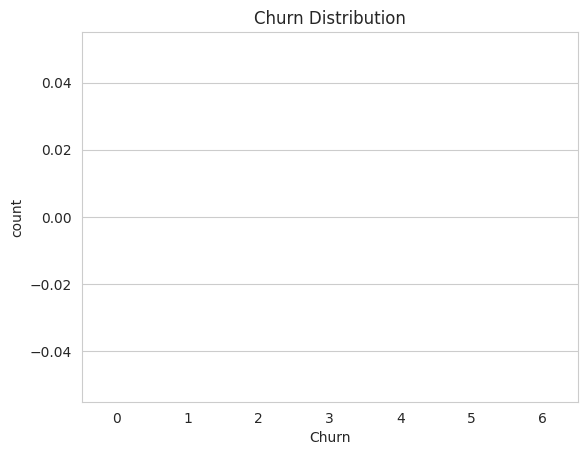

In [18]:
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

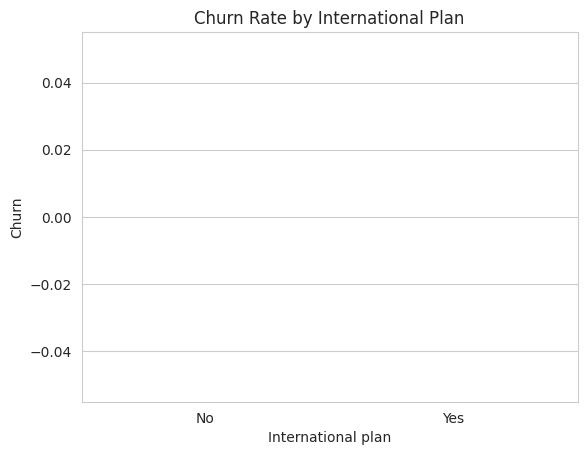

In [22]:
sns.barplot(x='International plan', y='Churn', data=df)
plt.title("Churn Rate by International Plan")
plt.show()

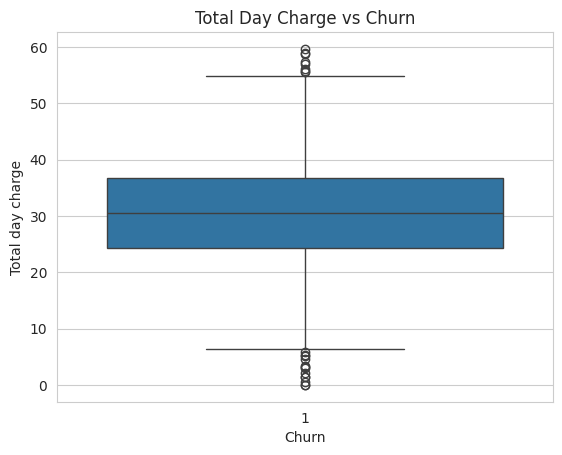

In [30]:
sns.boxplot(x='Churn', y='Total day charge', data=df)
plt.title("Total Day Charge vs Churn")
plt.show()

In [34]:
# Tenure grouping
df['TenureGroup'] = pd.cut(
    df['Account length'],
    bins=[0, 12, 24, 48, 60, 100],
    labels=['0-1yr', '1-2yr', '2-4yr', '4-5yr', '5+yr']
)

In [36]:
df['AvgMonthlySpend'] = df['Total day charge'] + df['Total eve charge'] + df['Total night charge'] + df['Total intl charge']

In [37]:
df_encoded = pd.get_dummies(df, drop_first=True)

df_encoded.head()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,AvgMonthlySpend,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,International plan_Yes,Voice mail plan_Yes,TenureGroup_1-2yr,TenureGroup_2-4yr,TenureGroup_4-5yr,TenureGroup_5+yr
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True


In [38]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [39]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_scaled, y_train
)

In [41]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_resampled, y_train_resampled)

y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

In [42]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       456
           1       0.32      0.62      0.42        78

    accuracy                           0.75       534
   macro avg       0.62      0.70      0.63       534
weighted avg       0.83      0.75      0.78       534



In [43]:
roc_auc_score(y_test, y_prob_log)

np.float64(0.7344242015294646)

In [44]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

In [45]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       456
           1       0.76      0.71      0.73        78

    accuracy                           0.93       534
   macro avg       0.86      0.83      0.84       534
weighted avg       0.92      0.93      0.92       534



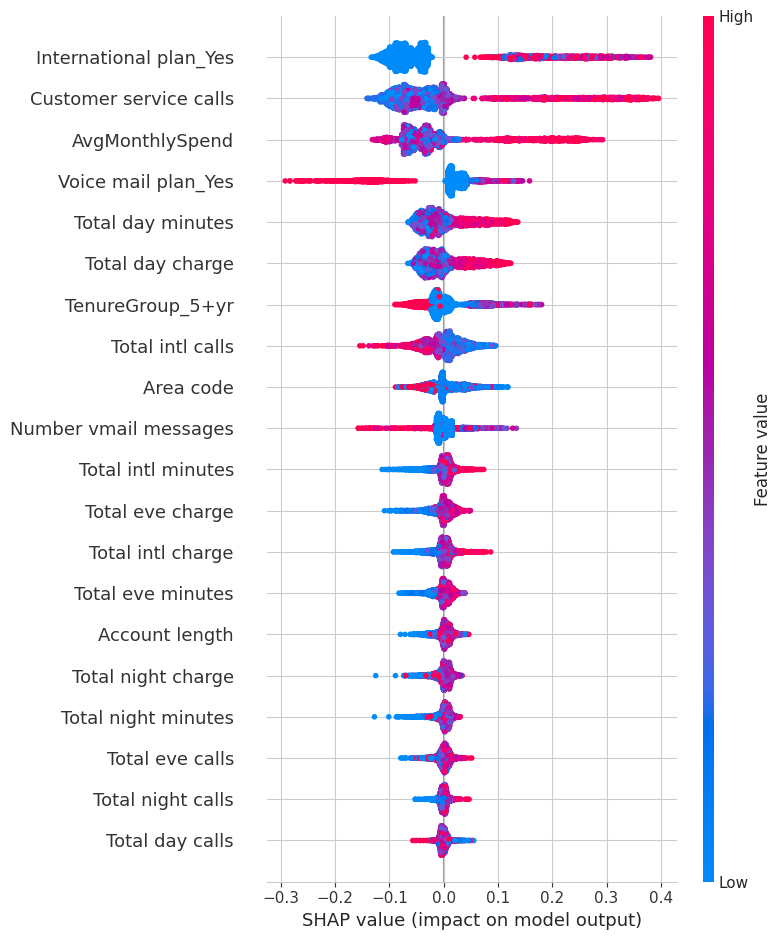

In [50]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_resampled)

X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
shap.summary_plot(shap_values[:, :, 1], X_train_resampled_df)

In [52]:
results = X_test.copy()
results['Churn_Probability'] = y_prob_rf

def risk_bucket(prob):
    if prob >= 0.7:
        return 'High Risk'
    elif prob >= 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

results['Risk_Level'] = results['Churn_Probability'].apply(risk_bucket)

In [53]:
def retention_action(row):
    if row['Risk_Level'] == 'High Risk' and row['AvgMonthlySpend'] > 70:
        return 'Offer Personalized Discount'
    elif row['Risk_Level'] == 'High Risk':
        return 'Engagement Campaign'
    elif row['Risk_Level'] == 'Medium Risk':
        return 'Loyalty Program'
    else:
        return 'No Action Required'

results['Retention_Action'] = results.apply(retention_action, axis=1)

In [54]:
high_risk = results[results['Risk_Level'] == 'High Risk']

estimated_revenue_saved = high_risk['AvgMonthlySpend'].sum() * 0.20

estimated_revenue_saved

np.float64(491.836)

In [55]:
results[['Churn_Probability', 'Risk_Level', 'Retention_Action']].head(10)

,Churn_Probability,Risk_Level,Retention_Action
1396,0.095,Low Risk,No Action Required
542,0.175,Low Risk,No Action Required
2275,0.110,Low Risk,No Action Required
1302,0.135,Low Risk,No Action Required
560,0.010,Low Risk,No Action Required
778,0.090,Low Risk,No Action Required
1730,0.110,Low Risk,No Action Required
2191,0.105,Low Risk,No Action Required
986,0.440,Medium Risk,Loyalty Program
459,0.115,Low Risk,No Action Required
